# Data Preprocessing

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve


import xgboost as xgb
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# Function to load specific datasets
def load_dataset():
    # Determine the current working directory
    current_dir = os.getcwd()
    
    # Create the path to the raw_data directory relative to the current directory
    base_dir = os.path.abspath(os.path.join(current_dir, "..", "raw_data"))
    
# Define the path to the All_Airports.csv file
    all_airports_file_path = os.path.join(base_dir, "All_Airports.csv")
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(all_airports_file_path, compression='zip')
    
    return df

df = load_dataset()

In [ ]:
#Inspect DF 

df.head()

### Missing Values

In [ ]:
#Select Numbers only
df_num = df.select_dtypes(include='number')
print(df_num.info())

In [ ]:
# Check Missing Values
missing_values = df.isnull().sum()

print(missing_values)

In [ ]:
len(df)

In [ ]:
# Display rows with missing values in 'DepDelayMinutes'
missing_dep_delay = df_num[df_num['DepDelayMinutes'].isnull()]
print(missing_dep_delay.head())

#### Inspect Missing Values in all relevant columns

In [ ]:
# Inspect specific columns with missing values
print(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].head(20))
print(df[['CancellationReason']].head(20))

In [ ]:
# Filter and inspect rows where DepDelayMinutes is NaN
print(df[df['DepDelayMinutes'].isnull()][['DepDelayMinutes', 'Delayed', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].head(20))

# Filter and inspect rows where WeatherDelay is NaN
print(df[df['WeatherDelay'].isnull()][['DepDelayMinutes', 'Delayed', 'WeatherDelay', 'CarrierDelay', 'NASDelay']].head(20))

# Filter and inspect rows where CancellationReason is NaN
print(df[df['CancellationReason'].isnull()][['CancellationReason', 'Cancelled']].head(20))

In [ ]:
# # Visualize missing data in the delay columns
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Data in Delay Columns')
# plt.show()

### Data Imputation for NaN

In [ ]:
# Impute NaN in delay columns with 0.0
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df[delay_columns] = df[delay_columns].fillna(0.0)

In [ ]:
# Impute NaN in DepDelayMinutes with 0.0
df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0.0)

In [ ]:
# Impute NaN in CancellationReason with 'Not Cancelled'
df['CancellationReason'] = df['CancellationReason'].fillna('Not Cancelled')

In [ ]:
# Display the first few rows after imputation to confirm changes
print(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationReason']].head(20))

### Handling Outliers

In [ ]:
# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3)
print(f"Outliers found: {len(outliers[0])}")

In [ ]:
# # Visualize outliers in specific columns
# for column in df.select_dtypes(include=[np.number]).columns:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=df[column])
#     plt.title(f'Boxplot of {column}')
#     plt.show()

### Manually Inspecting Extreme Outliers

In [ ]:
# Define a function to identify and print extreme outliers for a given feature
def inspect_outliers(df, feature):
    # Calculate the Interquartile Range (IQR)
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier criteria: below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify extreme outliers
    extreme_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    # Print information about the outliers
    print(f"Feature: {feature}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Number of Extreme Outliers: {len(extreme_outliers)}")
    print(extreme_outliers[[feature]].head(20))  # Show top 20 outliers for inspection
    print("\n" + "-"*80 + "\n")

# List of features for which to inspect outliers
features_to_inspect = [
    'DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
    'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature', 'Altimeter_Pressure', 
    'Sea_Level_Pressure', 'Visibility', 'Wind_Speed', 'Wind_Gust', 
    'Precipitation', 'Ice_Accretion_3hr'
]

# Loop through each feature and inspect outliers
for feature in features_to_inspect:
    inspect_outliers(df, feature)

### Manually Treating Extreme Outliers

In [ ]:
# Departure Delay Minutes
df['DepDelayMinutes'] = np.clip(df['DepDelayMinutes'], -15.0, 25.0)

In [ ]:
# Carrier Delay
df['CarrierDelay'] = np.clip(df['CarrierDelay'], 0.0, 390.0)

In [ ]:
#Weather Delay
df['WeatherDelay'] = np.clip(df['WeatherDelay'], 0.0, 140.0)

In [ ]:
#NASDelay
df['NASDelay'] = np.clip(df['NASDelay'], 0.0, 247.0)

In [ ]:
#Security Delay
df['SecurityDelay'] = np.clip(df['SecurityDelay'], 0.0, 146.0)

In [ ]:
#LateAircraft Delay
df['LateAircraftDelay'] = np.clip(df['LateAircraftDelay'], 0.0, 111.0)

In [ ]:
#Temperature
df['Temperature'] = np.clip(df['Temperature'], 13.5, 113.5)

In [ ]:
#Feels_Like_Temperature
df['Feels_Like_Temperature'] = np.clip(df['Feels_Like_Temperature'], 13.75, 113.35)

In [ ]:
#Altimeter Pressure
df['Altimeter_Pressure'] = np.clip(df['Altimeter_Pressure'], 1000.8449999999998, 1032.005)

In [ ]:
#Sea_Level_Pressure
df['Sea_Level_Pressure'] = np.clip(df['Sea_Level_Pressure'], 1003.05, 1029.05)

In [ ]:
#Visibility
df['Visibility'] = df['Visibility'].clip(lower=0, upper=16093.4)

In [ ]:
#Wind Speed
df['Wind_Speed'] = np.clip(df['Wind_Speed'], 0.0, 23.025)

In [ ]:
#Wind Gust
df['Wind_Gust'] = np.clip(df['Wind_Gust'], 20.42, 31.94)


In [ ]:
#Precipitation
df['Precipitation'] = np.clip(df['Precipitation'], 0.0, 5.59)

In [ ]:
#Ice Accretion
df['Ice_Accretion_3hr'] = np.clip(df['Ice_Accretion_3hr'], 0.0, 1.78)

In [ ]:
# # Identify outliers using Z-score
# z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
# outliers = np.where(z_scores > 3)
# print(f"Outliers found: {len(outliers[0])}")

# # Visualize outliers in specific columns
# for column in df.select_dtypes(include=[np.number]).columns:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=df[column])
#     plt.title(f'Boxplot of {column}')
#     plt.show()

#### Outliers Summary

After removing extreme outliets, a total of 1,954,889 outliers were kept. This means approximately 12.9% of our data points are classified as outliers using this method.
Given the size of our dataset, a large number of outliers might be expected, especially in a dataset with a variety of delay types and weather conditions.

### Clean Column Names to create a categorical y_pred before creating Train/Test Split

In [ ]:
# Check the datatype of the 'Time' column
print(f"Data type of 'Time': {df['Time'].dtype}")

# If not datetime, convert it to datetime
if not pd.api.types.is_datetime64_any_dtype(df['Time']):
    df['Time'] = pd.to_datetime(df['Time'])
    print(f"After conversion, Data type of 'Time': {df['Time'].dtype}")

In [ ]:
# Extract hour, day of the week, and month from the Time column
df['Hour'] = df['Time'].dt.hour
df['Day_Of_Week'] = df['Time'].dt.dayofweek
df['Month'] = df['Time'].dt.month

In [ ]:
# Rename the 'WeatherDelay' column to 'Weather_Delay_Length' for clarity before we create a new 'Binary' column
df.rename(columns={'WeatherDelay': 'Weather_Delay_Length'}, inplace=True)

# Verify the change
print(df.columns)

In [ ]:

# Create a new binary column 'WeatherDelay_Binary'
df['Weather_Delayed'] = df['Weather_Delay_Length'].apply(lambda x: 1 if x > 0 else 0)

# Check the first few rows to confirm
print(df[['Weather_Delay_Length', 'Weather_Delayed']].head(10))


In [ ]:

# Calculate the total number of instances
total = df['Weather_Delayed'].count()

# Calculate the percentage of each class
percent_delayed = (df['Weather_Delayed'].value_counts()[1] / total) * 100
percent_not_delayed = (df['Weather_Delayed'].value_counts()[0] / total) * 100

# Display the results
print(f"Percentage of delayed flights: {percent_delayed:.2f}%")
print(f"Percentage of not delayed flights: {percent_not_delayed:.2f}%")


## Save preprocessed file before test/split and Scaling

In [ ]:

# Function to save the DataFrame to the raw_data directory
def save_dataset(df):
    # Determine the current working directory
    current_dir = os.getcwd()
    
    # Create the path to the raw_data directory relative to the current directory
    base_dir = os.path.abspath(os.path.join(current_dir, "..", "data"))
    
    # Define the path to save the treated outliers DataFrame
    treated_outliers_file_path = os.path.join(base_dir, "preprocessed_treated_outliers.csv")
    
    # Save the DataFrame as a CSV file
    df.to_csv(treated_outliers_file_path, index=False)
    
# Call the function to save your DataFrame
save_dataset(df)

## Load preprocessed data

In [179]:
# Load preprocessed data set from /data folder
current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, "..", "data"))
file_path = os.path.join(base_dir, "preprocessed_treated_outliers.csv")
    
preprocessed_df = pd.read_csv(file_path)

print(preprocessed_df.head())

                  Time Origin Dest                 Carrier  Cancelled  \
0  2021-01-01 09:00:00    LAX  JFK  American Airlines Inc.      False   
1  2021-01-02 09:00:00    LAX  JFK  American Airlines Inc.      False   
2  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
3  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
4  2021-01-04 09:00:00    LAX  JFK  American Airlines Inc.      False   

  CancellationReason  Delayed  DepDelayMinutes  CarrierDelay  \
0      Not Cancelled    False              0.0           0.0   
1      Not Cancelled     True              2.0           0.0   
2      Not Cancelled     True             25.0          28.0   
3      Not Cancelled     True             25.0          28.0   
4      Not Cancelled    False              0.0           0.0   

   Weather_Delay_Length  ...  Sea_Level_Pressure  Visibility  Wind_Speed  \
0                   0.0  ...              1020.1    16093.40         0.0   
1                   0.0 

In [180]:
preprocessed_df.columns

Index(['Time', 'Origin', 'Dest', 'Carrier', 'Cancelled', 'CancellationReason',
       'Delayed', 'DepDelayMinutes', 'CarrierDelay', 'Weather_Delay_Length',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Temperature',
       'Feels_Like_Temperature', 'Altimeter_Pressure', 'Sea_Level_Pressure',
       'Visibility', 'Wind_Speed', 'Wind_Gust', 'Precipitation',
       'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month', 'Weather_Delayed'],
      dtype='object')

### Modelling for y_pred = 'Delayed'

In [ ]:
# # Define y_pred and drop X columns based on 'delayed' feature engineering
# X = preprocessed_df.drop(columns=['Cancelled', 'CancellationReason',
#        'Delayed', 'CarrierDelay', 'DepDelayMinutes', 'Weather_Delay_Length',
#        'NASDelay', 'SecurityDelay', 'LateAircraftDelay'])
# y = preprocessed_df['Delayed']

### Modelling for y_pred = 'Weather_Delayed'

In [181]:
# Define y_pred and drop X columns based on 'delayed' feature engineering
X = preprocessed_df.drop(columns=['Weather_Delay_Length', 'Weather_Delayed'])
y = preprocessed_df['Weather_Delayed']

### Split into train/test (applicable to all model variations)

In [182]:
#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Sampling down for testing 

In [183]:
# Sample only 10% of the data for quick testing
X_sample, _, y_sample, _ = train_test_split(
    X, y, 
    test_size=0.9,  # Keep only 10% for the sample
    random_state=42, 
    stratify=y  # Maintain the class distribution
)

### Split sampled data into train/test

In [184]:
# Split the sampled data into train and test sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, 
    test_size=0.2,  # 80% train, 20% test
    random_state=42, #Reproducibility
    stratify=y_sample  # Maintain the class distribution in the split
)

#### Enconding and scaling for y_pred = Weather_Delayed

In [185]:
# Identify categorical, binary, and numeric features
categorical_features = ['CancellationReason', 'Origin', 'Dest', 'Carrier']
binary_features = ['Cancelled', 'Delayed']
numeric_features = ['DepDelayMinutes', 'CarrierDelay', 'NASDelay',
                    'SecurityDelay', 'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature',
                    'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
                    'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month']

# One-hot encode categorical features
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train_sample[categorical_features])
X_test_encoded = encoder.transform(X_test_sample[categorical_features])

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sample[numeric_features])
X_test_scaled = scaler.transform(X_test_sample[numeric_features])

# Combine the encoded categorical, scaled numeric, and binary features into a single array
X_train_preprocessed = np.hstack([X_train_encoded.toarray(), X_train_scaled, X_train_sample[binary_features]])
X_test_preprocessed = np.hstack([X_test_encoded.toarray(), X_test_scaled, X_test_sample[binary_features]])

#### Enconding and scaling for y_pred = Delayed

In [ ]:
# # Identify categorical, binary, and numeric features
# categorical_features = ['Origin', 'Dest', 'Carrier']
# numeric_features = ['Temperature', 'Feels_Like_Temperature',
#                     'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
#                     'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month']

# # One-hot encode categorical features
# encoder = OneHotEncoder()
# X_train_encoded = encoder.fit_transform(X_train_sample[categorical_features])
# X_test_encoded = encoder.transform(X_test_sample[categorical_features])

# # Scale numeric features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_sample[numeric_features])
# X_test_scaled = scaler.transform(X_test_sample[numeric_features])


### PCA Analysis

In [186]:
#Assing PCA and number of components
pca = PCA(n_components=10)

#Apply PCA to scaled numeric features
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [187]:
#Concatenate arrays to form one array
X_train_preprocessed = np.hstack([X_train_encoded.toarray(), X_train_pca, X_train_sample[binary_features]])
X_test_preprocessed = np.hstack([X_test_encoded.toarray(), X_test_pca, X_test_sample[binary_features]])

In [188]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train_sample)

In [ ]:
# #Define Param Grid
# param_grid = {
#     'reg_alpha': [0, 0.5],  # L1
#     'reg_lambda': [0, 0.5],  # L2
#     'max_depth': [5, 10],  # Tree depth
#     'n_estimators': [100, 200]  # Boosting rounds
# }

### Initialise Model for Weather y_pred

In [189]:
# Initialize the XGBoost model
xgb_model_weather = xgb.XGBClassifier(
    use_label_encoder=False,  # Disable the use of the label encoder - Need to test if this is required or not
    eval_metric='logloss',  # logloss as the evaluation metric
    random_state=42,  # For reproducibility
)

### Grid Search

In [ ]:
# #Grid Search
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall', cv=3, n_jobs=-1)

In [ ]:
# #Fit Grid Search on balanced training data
# grid_search.fit(X_train_balanced, y_train_balanced)

In [ ]:
# #Print the best parameters and score
# print(f"Best Parameters from Grid Search: {grid_search.best_params_}")
# print(f"Best F1 Score from Grid Search: {grid_search.best_score_}")

## Model Fit

In [190]:
# Fit the model on the balanced training data
xgb_model_weather.fit(X_train_balanced, y_train_balanced)

/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Learning Curves

/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:21:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:21:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Sco

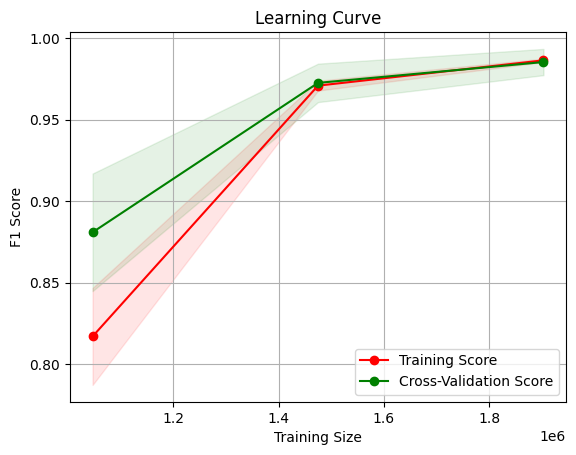

In [204]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the training sizes (fractions of the training set to use)
train_sizes = np.linspace(0.1, 1.0, 5)

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_model_weather,
    X=X_train_balanced,  # Use the balanced training data
    y=y_train_balanced,
    train_sizes=train_sizes,
    cv=5,  # 5-fold cross-validation
    scoring='recall',  # Use F1 score to measure performance
    n_jobs=-1  # Use all available CPU cores
)

# Calculate mean and standard deviation for training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-Validation Score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [192]:
# Evaluate the model on the test data
y_pred = xgb_model_weather.predict(X_test_preprocessed)

In [193]:
# Calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test_sample, y_pred)
print(f"F1 Score on the test set: {f1}")

F1 Score on the test set: 0.3374604538530641


In [194]:
#Calculate Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test_sample, y_pred)
print(f"Recall: {recall}")

Recall: 0.7853117614979095


In [195]:
# Calculate ROC AUC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test_sample, y_pred)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.8661217000434839


In [196]:
# Inspect Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_sample, y_pred)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[281608  15782]
 [  1181   4320]]


In [197]:
# Generate Classifiation Report
from sklearn.metrics import classification_report
report = classification_report(y_test_sample, y_pred)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    297390
           1       0.21      0.79      0.34      5501

    accuracy                           0.94    302891
   macro avg       0.61      0.87      0.65    302891
weighted avg       0.98      0.94      0.96    302891



#### Plot Feature Importance

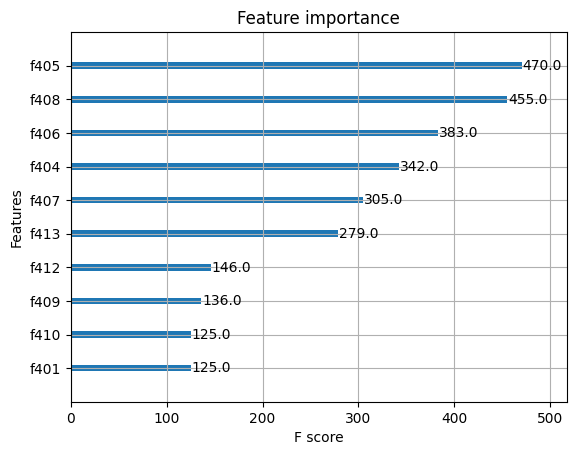

In [198]:
# Plot the feature importance
plot_importance(xgb_model_weather, max_num_features=10)
plt.show()

In [199]:
# Get the feature names from the encoder
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

In [200]:
# Combine feature names
all_feature_names = np.hstack([
    encoded_feature_names,  # Encoded categorical feature names
    numeric_features,        # Numeric feature names
    # binary_features          # Binary feature names
])

In [201]:
# Mapping indices to feature names
important_features = [(all_feature_names[i], importance) for i, importance in enumerate(xgb_model_weather.feature_importances_)]

# Sort by importance
important_features.sort(key=lambda x: x[1], reverse=True)

# Display top important features
for feature, importance in important_features[:30]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Wind_Gust, Importance: 0.4621961712837219
Feature: Dest_MCO, Importance: 0.014909054152667522
Feature: Dest_LAS, Importance: 0.012456043623387814
Feature: Dest_SFO, Importance: 0.010744232684373856
Feature: Dest_LAX, Importance: 0.010512880980968475
Feature: Dest_BOS, Importance: 0.010074708610773087
Feature: Dest_RDU, Importance: 0.00962947215884924
Feature: Dest_LGA, Importance: 0.009146403521299362
Feature: Dest_MIA, Importance: 0.008627929724752903
Feature: Dest_AUS, Importance: 0.008581124246120453
Feature: Dest_ORD, Importance: 0.008525419980287552
Feature: Dest_DCA, Importance: 0.008408940397202969
Feature: Dest_IAH, Importance: 0.008374358527362347
Feature: Dest_PHX, Importance: 0.007955426350235939
Feature: Dest_CLT, Importance: 0.007718477863818407
Feature: Dest_JFK, Importance: 0.0076573011465370655
Feature: Dest_DEN, Importance: 0.007655532099306583
Feature: Dest_SAN, Importance: 0.007454147096723318
Feature: Dest_SLC, Importance: 0.007418455556035042
Feature: Dest

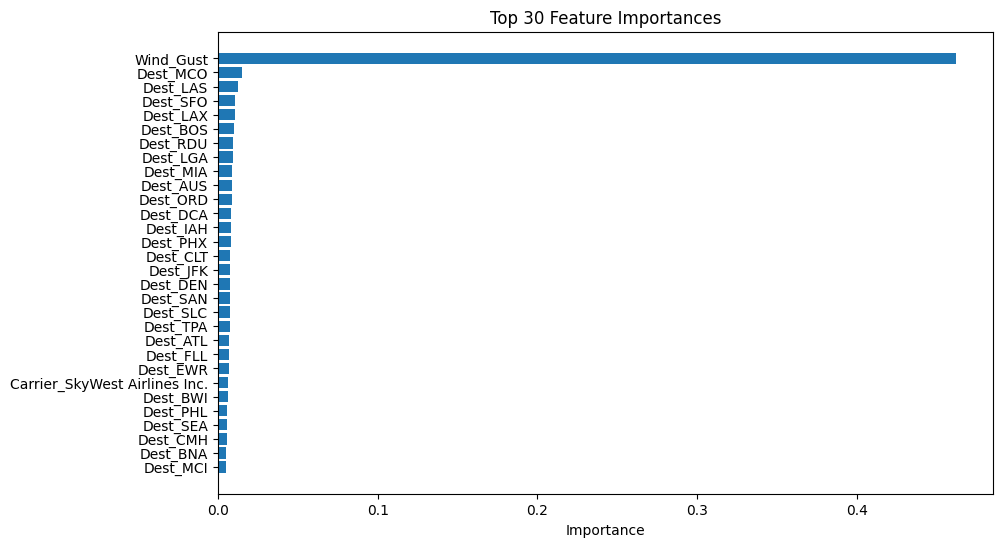

In [203]:
# Sort the important features by importance
important_features.sort(key=lambda x: x[1], reverse=True)

# Extract the top 10 features and their importance
top_features = important_features[:30]
features = [f[0] for f in top_features]
importances = [f[1] for f in top_features]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis() 
plt.show()

# XGBoost

## Preprocessing Pipelines

In [ ]:
# # Define categorical, binary, and numeric features
# categorical_features = ['CancellationReason', 'Origin', 'Dest', 'Carrier']
# binary_features = ['Cancelled', 'Delayed']
# numeric_features = ['DepDelayMinutes', 'CarrierDelay', 'NASDelay',
#                     'SecurityDelay', 'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature',
#                     'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
#                     'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month']

# # Define the preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(), categorical_features),  # Encode categorical features
#         ('passthrough_binary', 'passthrough', binary_features),  # Pass binary features as is
#         ('passthrough_numeric', 'passthrough', numeric_features)  # Pass numeric features as is
#     ],
#     remainder='drop'  # Drop the Time column and any other unspecified features
# )

## Scaling, Balacing & Modeling with Pipelines

### StandardScaler + SMOTE Pipeline

In [ ]:
# # Pipeline with StandardScaler and SMOTE, with XGBClassifier model
# pipeline_ss_smote = ImbPipeline([
#     ('preprocessor', preprocessor), #Preprocessor
#     ('scaler', StandardScaler(with_mean=False)),  # Standard Scaler for normalising features
#     ('sampling', SMOTE(random_state=42)),  # SMOTE for oversampling the minority class
# ])

In [ ]:
# # Grid Search parameters for Standard Scaler + SMOTE + XGBoost
# param_grid_ss_smote = {
#     'classifier__n_estimators': [100],  # Number of boosting rounds
#     'classifier__max_depth': [5]  # Maximum depth of the trees
# }

In [ ]:
# # Cross-validation strategy
# cv = StratifiedKFold(n_splits=5)

In [ ]:
# #Small X_train sample for local testing
# X_train_sample, _, y_train_sample, _ = train_test_split(
#     X_train, y_train, 
#     test_size=0.9,  # Keep only 10% for the sample
#     random_state=42
# )

In [ ]:
# X_train_sample

In [ ]:
# # Running GridSearch
# grid_search_ss_smote_sample = GridSearchCV(pipeline_ss_smote, param_grid_ss_smote, cv=cv, scoring='f1', n_jobs=-1)

In [ ]:
# #Fit X_train_sample and y_train_sample
# grid_search_ss_smote_sample.fit(X_train_sample, y_train_sample)

In [ ]:
# # Store results
# best_model_ss_smote = grid_search_ss_smote_sample.best_estimator_
# print(f"Best Parameters for SS + SMOTE: {grid_search_ss_smote_sample.best_params_}")
# print(f"Best F1 Score from Sample Grid Search: {grid_search_ss_smote_sample.best_score_}")